### **Sentiment Analysis using tweets fetched from Twitter**<br>

Connect with Google Drive.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Import libraries and ignore warnings

In [ ]:
# imports
import pandas as pd
import sys

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

Read data from .pkl file

In [ ]:
df = pd.read_pickle("/content/gdrive/MyDrive/tede/eclass_all_with_sentiment_v2.pkl")

Replace sentiments with integer ids.

In [ ]:
def sentiment_to_id(x):
  if x == 'NEG':
    return -1
  if x == 'NEU':
    return 0
  if x == 'POS':
    return 1

df['sentiment_ids'] = df['sentiment'].apply(sentiment_to_id)

Data cleansing

In [ ]:
# 1. Pre-processing and analyzing of the data
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
import numpy as np

nltk.download('stopwords')
nltk.download('wordnet')
stopwords = set(stopwords.words("english"))
stopwords.remove("not")

df['text'] = df['text'].str.lower() # lowercase
df['text'] = df['text'].str.replace("n\'t", " not")
df['text'] = df['text'].str.replace("n\’t", " not")
df['text'] = df['text'].str.replace(r'http\S+', '', regex=True).replace(r'www\S+', '', regex=True) # remove links
df['text'] = df['text'].str.replace("#[A-Za-z0-9_]+",'') # remove hashtags
df['text'] = df['text'].str.replace('@[A-Za-z0-9_]+','') # remove mentions
df = df.astype(str).apply(lambda x: x.str.encode('ascii', 'ignore').str.decode('ascii')) # remove emojis
df['text'] = df['text'].str.replace('[^\w\s]','') # remove punctuation
df['text'] = df['text'].str.replace('[^A-Za-z ]+', '')
df['text'] = df['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in stopwords])) #remove stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: FutureWarning: The default value of regex will change from True to False in a future version.
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: FutureWarning: The default value of regex will change from True to False in a future version.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: FutureWarning: The default value of regex will change from True to False in a future version.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: FutureWarning: The default value of regex will change from True to False in a future version.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: FutureWarning: The default value of regex will change from True to False in a future version.


Split train and test datasets (0.8-0.2) and save to .tsv

In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np

x_train, x_test, y_train, y_test = train_test_split(df['text'], df['sentiment_ids'], train_size = 0.8) #, shuffle=True, stratify=df['sentiment_ids']

train = pd.concat([x_train, y_train], axis=1)
train.to_csv('train.tsv', sep = '\t')
test = pd.concat([x_test, y_test], axis=1)
test.to_csv('test.tsv', sep = '\t')

train = pd.read_csv('train.tsv', sep='\t', index_col=0, squeeze=True, dtype = object)
train = train.dropna()
x_train = train['text']
y_train = train['sentiment_ids']

test = pd.read_csv('test.tsv', sep='\t', index_col=0, squeeze=True, dtype = object)
test = test.dropna()
x_test = test['text']
y_test = test['sentiment_ids']

Sentiments distribution

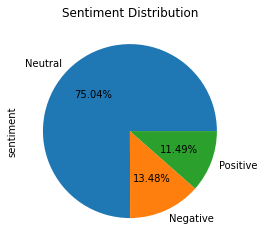

In [ ]:
# 2.1 sentiment distribution
import matplotlib.pyplot as plt

sentiment_distribution = df['sentiment'].value_counts().plot(kind='pie', labels=['Neutral','Negative','Positive'], autopct='%.2f%%', title='Sentiment Distribution')

Most common words among the dataset:

In [ ]:
# 2.2 most common words
most_common_words_overall = pd.Series(' '.join(df['text']).split()).value_counts()[:20]
most_common_words_overall

dose          50283
vaccine       41405
slots         23263
not           19006
covaxin       17375
covid         17136
age           13201
got           12864
first         12779
pincode       12254
slotsage      12212
fees          11478
vaccines      11118
hospital      10323
get            9831
vaccinated     9708
amp            9432
doses          9241
shot           9107
today          8815
dtype: int64

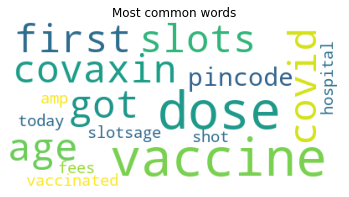

In [ ]:
from wordcloud import WordCloud

# wordcloud = WordCloud(max_font_size=61.8, max_words=20, background_color="white").generate(' '.join([word[1] for word in df['text'].iteritems()]))
my = most_common_words_overall.to_dict()
wordcloud = WordCloud(max_font_size=61.8, max_words=20, background_color="white").generate(' '.join(x for x in my.keys()))
plt.axis('off')
plt.title("Most common words")
plt.imshow(wordcloud)

Most common words per sentiment category:

In [ ]:
# 2.3 most common words per sentiment catergory
most_common_words = [pd.Series(' '.join(df.loc[df['sentiment'] == sentiment]['text']).split()).value_counts()[:20] for sentiment in ["NEU", "POS", "NEG"]]

(-0.5, 399.5, 199.5, -0.5)

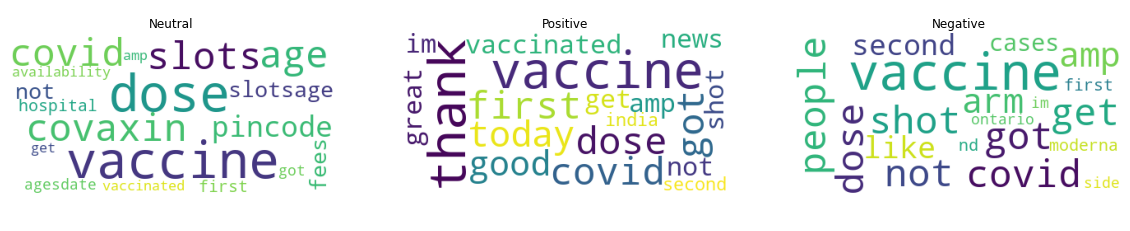

In [ ]:
from wordcloud import WordCloud

fig, ax = plt.subplots(1,3, figsize=(20,4))

neutral_wordcloud = WordCloud(max_font_size=61.8, max_words=20, background_color="white", stopwords={}).generate(' '.join([word[0] for word in most_common_words[0].iteritems()]))
positive_wordcloud = WordCloud(max_font_size=61.8, max_words=20, background_color="white", stopwords={}).generate(' '.join([word[0] for word in most_common_words[1].iteritems()]))
negative_wordcloud = WordCloud(max_font_size=61.8, max_words=20, background_color="white", stopwords={}).generate(' '.join([word[0] for word in most_common_words[2].iteritems()]))
[axi.set_axis_off() for axi in ax.ravel()]

ax[0] = fig.add_subplot(1,3,1)
ax[0].imshow(neutral_wordcloud)
ax[0].set_title("Neutral")
ax[0].axis('off')

ax[1] = fig.add_subplot(1,3,2)
ax[1].imshow(positive_wordcloud)
ax[1].set_title("Positive")
ax[1].axis('off')

ax[2] = fig.add_subplot(1,3,3)
ax[2].imshow(negative_wordcloud)
ax[2].set_title("Negative")
ax[2].axis('off')

Sentiments distribution per vaccine category:

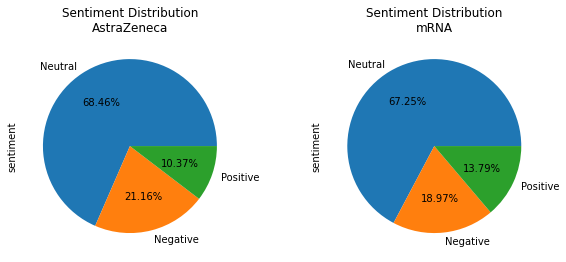

In [ ]:
# 2.4 Sentiment distribution between AstraZeneca and mRNA vaccines
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,4))

subset_astrazeneca = df[df['text'].str.contains("astrazeneca")]
subset_mrna = df[df['text'].str.contains("moderna|pfizer|biontech")]
subset_astrazeneca['sentiment'].value_counts().plot(kind='pie', labels=['Neutral','Negative','Positive'], autopct='%.2f%%', title='Sentiment Distribution\nAstraZeneca', ax=ax1)
subset_mrna['sentiment'].value_counts().plot(kind='pie', labels=['Neutral','Negative','Positive'], autopct='%.2f%%', title='Sentiment Distribution\nmRNA', ax=ax2)

The negative portion is larger for the AstraZeneca vaccine, compared to this of mRNA vaccines.

Number of tweets per month:

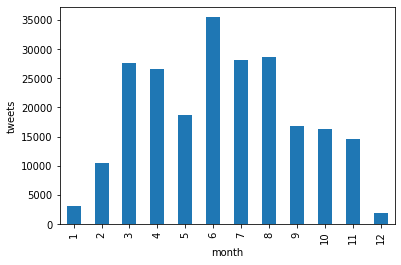

In [ ]:
# 2.5 Number of tweets per month
df['date']= pd.to_datetime(df['date'])
df.groupby([df['date'].dt.month]).size().plot(kind='bar', xlabel='month', ylabel='tweets')

Some more observations regarding the data include the sentiments distribution over time:

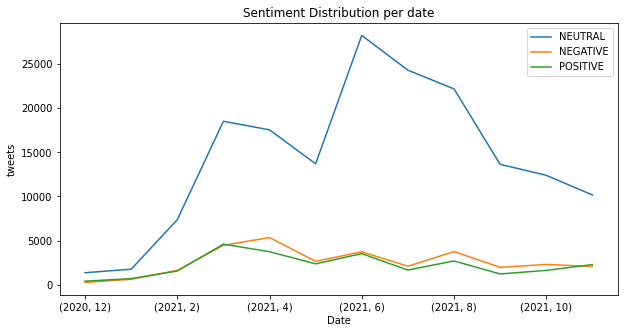

In [ ]:
df['date'] = pd.to_datetime(df['date'])
new_df = df.loc[df['sentiment'] == 'NEU']
new_df.groupby([(new_df['date'].dt.year), (new_df['date'].dt.month)]).size().plot(xlabel='Date', ylabel='tweets', label='NEUTRAL', title='Sentiment Distribution per date', legend=True, figsize=(10,5))

new_df = df.loc[df['sentiment'] == 'NEG']
new_df.groupby([(new_df['date'].dt.year), (new_df['date'].dt.month)]).size().plot(xlabel='Date', ylabel='tweets', label='NEGATIVE', title='Sentiment Distribution per date', legend=True, figsize=(10,5))

new_df = df.loc[df['sentiment'] == 'POS']
new_df.groupby([(new_df['date'].dt.year), (new_df['date'].dt.month)]).size().plot(xlabel='Date', ylabel='tweets', label='POSITIVE', title='Sentiment Distribution per date', legend=True, figsize=(10,5))

Number of tweets per vaccine over time:

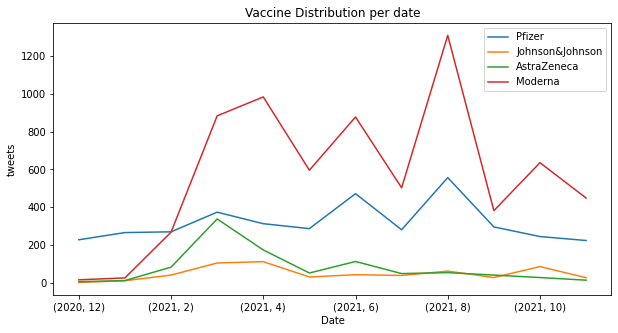

In [ ]:
df['date'] = pd.to_datetime(df['date'])
new_df = df.loc[df['text'].str.contains("pfizer|biontech")]
new_df.groupby([(new_df['date'].dt.year), (new_df['date'].dt.month)]).size().plot(xlabel='Date', ylabel='tweets', label='Pfizer', title='Vaccine Distribution per date', legend=True, figsize=(10,5))

new_df = df.loc[df['text'].str.contains("johnson|jj")]
new_df.groupby([(new_df['date'].dt.year), (new_df['date'].dt.month)]).size().plot(xlabel='Date', ylabel='tweets', label='Johnson&Johnson', title='Vaccine Distribution per date', legend=True, figsize=(10,5))

new_df = df.loc[df['text'].str.contains("astrazeneca")]
new_df.groupby([(new_df['date'].dt.year), (new_df['date'].dt.month)]).size().plot(xlabel='Date', ylabel='tweets', label='AstraZeneca', title='Vaccine Distribution per date', legend=True, figsize=(10,5))

new_df = df.loc[df['text'].str.contains("moderna")]
new_df.groupby([(new_df['date'].dt.year), (new_df['date'].dt.month)]).size().plot(xlabel='Date', ylabel='tweets', label='Moderna', title='Vaccine Distribution per date', legend=True, figsize=(10,5))

Create characteristics for 'text' column (vectorization) using Bag-of-Words and save to .pkl:

In [ ]:
# 3.1 Bag-of-Words

import pickle
from sklearn.feature_extraction.text import CountVectorizer

bow_vectorizer = CountVectorizer(max_df=1.0, min_df=1, max_features=1000, stop_words='english')

bow_xtrain = bow_vectorizer.fit_transform(x_train)
bow_xtest = bow_vectorizer.fit_transform(x_test)

output = open('bow_xtrain.pkl', 'wb')
pickle.dump(bow_xtrain, output)
output.close()

output = open('bow_xtest.pkl', 'wb')
pickle.dump(bow_xtest, output)
output.close()

pkl_file_train = open('bow_xtrain.pkl', 'rb')
bow_xtrain = pickle.load(pkl_file_train)

pkl_file_test = open('bow_xtest.pkl', 'rb')
bow_xtest = pickle.load(pkl_file_test)

print(bow_xtrain.shape)
print(bow_xtest.shape)

(180971, 1000)
(45249, 1000)


Create characteristics for 'text' column (vectorization) using Tf-Idf and save to .pkl:

In [ ]:
# 3.2 Tf-idf

import pickle
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(max_df=1.0, min_df=1, max_features=1000, stop_words='english')
tfidf_xtrain = tfidf_vectorizer.fit_transform(x_train)
tfidf_xtest = tfidf_vectorizer.fit_transform(x_test)

output = open('tfidf_xtrain.pkl', 'wb')
pickle.dump(tfidf_xtrain, output)
output.close()

output = open('tfidf_xtest.pkl', 'wb')
pickle.dump(tfidf_xtest, output)
output.close()

pkl_file_train = open('tfidf_xtrain.pkl', 'rb')
tfidf_xtrain = pickle.load(pkl_file_train)

pkl_file_test = open('tfidf_xtest.pkl', 'rb')
tfidf_xtest = pickle.load(pkl_file_test)

print(tfidf_xtrain.shape)
print(tfidf_xtest.shape)

(180971, 1000)
(45249, 1000)


Create characteristics for 'text' column (vectorization) using Word Embeddings and save to .pkl:

In [ ]:
# 3.3 Word embeddings
import numpy as np

def get_new_vec(model, size, sentence):
    vector = np.zeros(size).reshape(1,size)
    count = 0
    for word in sentence:
        try:
            vector += model[word].reshape(1,size)
            count += 1
        except:
            continue
    if count != 0:
        vector /= count
    return vector

# !pip install --upgrade gensim
import gensim
from gensim.models import Word2Vec

tokenized_tweet = x_train.apply(lambda x: x.split())
model_w2v = gensim.models.Word2Vec(tokenized_tweet, vector_size=200, window=5, min_count=2, sg = 1, hs = 0, negative = 10, workers= 2, seed = 34)
model_w2v.train(tokenized_tweet, total_examples = len(x_train), epochs=20)

train_vec = np.concatenate([get_new_vec(model_w2v, 200, sentence) for sentence in x_train])

tokenized_tweet = x_test.apply(lambda x: x.split())
model_w2v = gensim.models.Word2Vec(tokenized_tweet, vector_size=200, window=5, min_count=2, sg = 1, hs = 0, negative = 10, workers= 2, seed = 34)
model_w2v.train(tokenized_tweet, total_examples = len(x_test), epochs=20)

test_vec = np.concatenate([get_new_vec(model_w2v, 200, sentence) for sentence in x_test])

output = open('train_vec.pkl', 'wb')
pickle.dump(train_vec, output)
output.close()

output = open('test_vec.pkl', 'wb')
pickle.dump(test_vec, output)
output.close()

pkl_file_train = open('train_vec.pkl', 'rb')
train_vec = pickle.load(pkl_file_train)

pkl_file_test = open('test_vec.pkl', 'rb')
test_vec = pickle.load(pkl_file_test)

print(train_vec.shape)
print(test_vec.shape)

     |████████████████████████████████| 24.1 MB 1.5 MB/s 
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0
(180971, 200)
(45249, 200)


Initialize a function that calculates several metrics for every calssifier and characteristics set.

In [ ]:
#4.
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import cross_validate
import numpy as np
from numpy import mean

scoring = { 'precision' : make_scorer(precision_score, average = 'macro', zero_division=1),
           'recall' : make_scorer(recall_score, average = 'macro', zero_division=1),
           'f1_score' : make_scorer(f1_score, average = 'macro', zero_division=1), 
           'accuracy' : 'accuracy' }


def get_mean_scores(model, X, Y, scoring = 'accuracy', cv = 5) :
  score = cross_validate(model, X, Y, scoring = scoring, cv = cv)
  return {keys : np.mean(vals) for keys, vals in score.items()}

SVM classifier using Bag-of-Words, perform 10-fold Cross Validation using Precision/Recall/F-Measure and Accuracy metrics, then save to .pkl

In [ ]:
# 4. Estimators - SVM/BOW

from sklearn.svm import SVC

clf = SVC()
clf.fit(bow_xtrain, y_train)

scores_svc_bow = get_mean_scores(clf, bow_xtest, y_test, scoring = scoring, cv = 10)
output = open('/content/gdrive/My Drive/tede/scores_svc_bow.pkl', 'wb')
pickle.dump(scores_svc_bow, output)
output.close()
print("Precision score ", scores_svc_bow['test_precision'], "\nRecall score ", scores_svc_bow['test_recall'], "\nf1 score ", scores_svc_bow['test_f1_score'], "\nAccuracy score ", scores_svc_bow['test_accuracy'])

Precision score  0.7820510272800217 
Recall score  0.5691177169380337 
f1 score  0.6205838345600754 
Accuracy score  0.8158731577687568


SVM classifier using Tf-Idf, perform 10-fold Cross Validation using Precision/Recall/F-Measure and Accuracy metrics, then save to .pkl

In [ ]:
# 4. Estimators - SVM/TF-IDF

from sklearn.svm import SVC
import numpy as np

clf = SVC()
clf.fit(tfidf_xtrain, y_train)
scores_svc_tfidf = get_mean_scores(clf, tfidf_xtest, y_test, scoring = scoring, cv = 10)
output = open('/content/gdrive/My Drive/tede/scores_svc_tfidf.pkl', 'wb')
pickle.dump(scores_svc_tfidf, output)
output.close()
print("Precision score ", scores_svc_tfidf['test_precision'], "\nRecall score ", scores_svc_tfidf['test_recall'], "\nf1 score ", scores_svc_tfidf['test_f1_score'], "\nAccuracy score ", scores_svc_tfidf['test_accuracy'])

Precision score  0.7765558504409517 
Recall score  0.5716497010448809 
f1 score  0.6243244039032209 
Accuracy score  0.8148246943251707


SVM classifier using Word Embeddings, perform 10-fold Cross Validation using Precision/Recall/F-Measure and Accuracy metrics, then save to .pkl

In [ ]:
# 4. Estimators - SVM/WORD EMBEDDINGS

from sklearn.svm import SVC
import numpy as np

clf = SVC()
clf.fit(train_vec, y_train)
scores_svc_we = get_mean_scores(clf, test_vec, y_test, scoring = scoring, cv = 10)
output = open('/content/gdrive/My Drive/tede/scores_svc_we.pkl', 'wb')
pickle.dump(scores_svc_we, output)
output.close()
print("Precision score ", scores_svc_we['test_precision'], "\nRecall score ", scores_svc_we['test_recall'], "\nf1 score ", scores_svc_we['test_f1_score'], "\nAccuracy score ", scores_svc_we['test_accuracy'])

Precision score  0.91595394482954 
Recall score  0.33333333333333337 
f1 score  0.2852482650237499 
Accuracy score  0.7478618344886205


Random Forest classifier using Bag-Of-Words, perfrom 10-fold Cross Validation using Precision/Recall/F-Measure and Accuracy metrics, then save to .pkl

In [ ]:
# 4. Estimators - RANDOMFORESTS/BOW

from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(max_depth=30)
clf.fit(bow_xtrain, y_train)

scores_rf_bow = get_mean_scores(clf, bow_xtest, y_test, scoring = scoring, cv = 10)
output = open('/content/gdrive/My Drive/tede/scores_rf_bow.pkl', 'wb')
pickle.dump(scores_rf_bow, output)
output.close()
print("Precision score ", scores_rf_bow['test_precision'], "\nRecall score ", scores_rf_bow['test_recall'], "\nf1 score ", scores_rf_bow['test_f1_score'], "\nAccuracy score ", scores_rf_bow['test_accuracy'])

Precision score  0.8210853504798055 
Recall score  0.44934223501100795 
f1 score  0.4849169088389975 
Accuracy score  0.7851444328834308


Random Forest classifier using Tf-Idf, perform 10-fold Cross Validation using Precision/Recall/F-Measure and Accuracy metrics, then save to .pkl

In [ ]:
# 4. Estimators - RANDOMFORESTS/TF-IDF

from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(max_depth=30)
clf.fit(tfidf_xtrain, y_train)

scores_rf_tfidf = get_mean_scores(clf, tfidf_xtest, y_test, scoring = scoring, cv = 10)
output = open('/content/gdrive/My Drive/tede/scores_rf_tfidf.pkl', 'wb')
pickle.dump(scores_rf_tfidf, output)
output.close()
print("Precision score ", scores_rf_tfidf['test_precision'], "\nRecall score ", scores_rf_tfidf['test_recall'], "\nf1 score ", scores_rf_tfidf['test_f1_score'], "\nAccuracy score ", scores_rf_tfidf['test_accuracy'])

Precision score  0.8137328718330255 
Recall score  0.4531644874167067 
f1 score  0.4887411487377764 
Accuracy score  0.785497970309363


Random Forest classifier using Word Embeddings, perform 10-fold Cross Validation using Precision/Recall/F-Measure and Accuracy metrics, then save to .pkl

In [ ]:
# 4. Estimators - RANDOMFORESTS/WORD EMBEDDINGS

from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(max_depth=30)
clf.fit(train_vec, y_train)
scores_rf_we = get_mean_scores(clf, test_vec, y_test, scoring = scoring, cv = 10)
output = open('/content/gdrive/My Drive/tede/scores_rf_we.pkl', 'wb')
pickle.dump(scores_rf_we, output)
output.close()
print("Precision score ", scores_rf_we['test_precision'], "\nRecall score ", scores_rf_we['test_recall'], "\nf1 score ", scores_rf_we['test_f1_score'], "\nAccuracy score ", scores_rf_we['test_accuracy'])

Precision score  0.91595394482954 
Recall score  0.33333333333333337 
f1 score  0.2852482650237499 
Accuracy score  0.7478618344886205


K-Nearest Neighbor classifier using Bag-of-Words, perform 10-fold Cross Validation using Precision/Recall/F-Measure and Accuracy metrics, then save to .pkl

In [ ]:
# 4. Estimators - KNN/BOW

from sklearn.neighbors import KNeighborsClassifier

neigh = KNeighborsClassifier(n_neighbors=10)
neigh.fit(bow_xtrain, y_train)
scores_knn_bow = get_mean_scores(neigh, bow_xtest, y_test, scoring = scoring, cv = 10)
output = open('/content/gdrive/My Drive/tede/scores_knn_bow.pkl', 'wb')
pickle.dump(scores_knn_bow, output)
output.close()
print("Precision score ", scores_knn_bow['test_precision'], "\nRecall score ", scores_knn_bow['test_recall'], "\nf1 score ", scores_knn_bow['test_f1_score'], "\nAccuracy score ", scores_knn_bow['test_accuracy'])

Precision score  0.698573304592618 
Recall score  0.41617409273855116 
f1 score  0.43642837247100275 
Accuracy score  0.7671329044360098


K-Nearest Neighbor classifier using Tf-Idf, perform 10-fold Cross Validation using Precision/Recall/F-Measure and Accuracy metrics, then save to .pkl

In [ ]:
# 4. Estimators - KNN/TF-IDF

from sklearn.neighbors import KNeighborsClassifier

neigh = KNeighborsClassifier(n_neighbors=10)
neigh.fit(tfidf_xtrain, y_train)

scores_knn_tfidf = get_mean_scores(neigh, tfidf_xtest, y_test, scoring = scoring, cv = 10)
output = open('/content/gdrive/My Drive/tede/scores_knn_tfidf.pkl', 'wb')
pickle.dump(scores_knn_tfidf, output)
output.close()
print("Precision score ", scores_knn_tfidf['test_precision'], "\nRecall score ", scores_knn_tfidf['test_recall'], "\nf1 score ", scores_knn_tfidf['test_f1_score'], "\nAccuracy score ", scores_knn_tfidf['test_accuracy'])

Precision score  0.7026374510460827 
Recall score  0.4647007784276488 
f1 score  0.5040496835954309 
Accuracy score  0.7769895608931616


K-Nearest Neighbor classifier using Word Embeddings, perform 10-fold Cross Validation using Precision/Recall/F-Measure and Accuracy metrics, then save to .pkl

In [ ]:
# 4. Estimators - KNN/WORD EMBEDDINGS

from sklearn.neighbors import KNeighborsClassifier

neigh = KNeighborsClassifier(n_neighbors=10)
neigh.fit(train_vec, y_train)

scores_knn_we = get_mean_scores(neigh, test_vec, y_test, scoring = scoring, cv = 10)
output = open('/content/gdrive/My Drive/tede/scores_knn_we.pkl', 'wb')
pickle.dump(scores_knn_we, output)
output.close()
print("Precision score ", scores_knn_we['test_precision'], "\nRecall score ", scores_knn_we['test_recall'], "\nf1 score ", scores_knn_we['test_f1_score'], "\nAccuracy score ", scores_knn_we['test_accuracy'])

Precision score  0.8955708877393006 
Recall score  0.33333333333333337 
f1 score  0.26472328062033973 
Accuracy score  0.6867126632179023


Stemming and lemmatization

In [ ]:
#5.
#stem and lemmatize
def clean_words(text) :
    tokens = text.split()
    ps = PorterStemmer()
    stemmed_tokens = [ps.stem(x) for x in tokens]
    lemmatizer = WordNetLemmatizer()
    return ' '.join( [lemmatizer.lemmatize(x, pos='a') for x in stemmed_tokens])

df['text'] = df['text'].apply(clean_words)

Tokenization of tweets and creation of a dictionary with an id for every word contained in the tweets.

In [ ]:
from gensim.corpora import Dictionary

tweets_list = df['text'].values.tolist()
tweets_tokens = [tweet.split() for tweet in tweets_list]

tweets_dict = Dictionary(tweets_tokens)
tweets_dict.token2id

{'could': 0,
 'cytokin': 1,
 'daikon': 2,
 'folk': 3,
 'past': 4,
 'said': 5,
 'storm': 6,
 'treat': 7,
 'big': 8,
 'effort': 9,
 'ev': 10,
 'histori': 11,
 'hope': 12,
 'side': 13,
 'vaccin': 14,
 'weve': 15,
 'world': 16,
 'wrong': 17,
 'year': 18,
 'creat': 19,
 'last': 20,
 'russian': 21,
 'acknowledg': 22,
 'born': 23,
 'enough': 24,
 'ethic': 25,
 'even': 26,
 'fact': 27,
 'immut': 28,
 'not': 29,
 'senat': 30,
 'sturdi': 31,
 'your': 32,
 'explain': 33,
 'need': 34,
 'adviceguid': 35,
 'anyon': 36,
 'breastfeed': 37,
 'covid': 38,
 'safe': 39,
 'use': 40,
 'whether': 41,
 'whilst': 42,
 'bit': 43,
 'canada': 44,
 'claim': 45,
 'competit': 46,
 'fame': 47,
 'patriot': 48,
 'sad': 49,
 'success': 50,
 'uk': 51,
 'usa': 52,
 'best': 53,
 'bright': 54,
 'day': 55,
 'mani': 56,
 'win': 57,
 'get': 58,
 'monday': 59,
 'say': 60,
 'start': 61,
 'state': 62,
 'close': 63,
 'death': 64,
 'first': 65,
 'mark': 66,
 'million': 67,
 'peopl': 68,
 'u': 69,
 'wait': 70,
 'us': 71,
 'wish': 72

Creation of Bag-of-Words using doc2bow method of gensim.

In [ ]:
tweets_bow = [tweets_dict.doc2bow(tweet) for tweet in tweets_tokens] 

LDA Model creation using 10 topics and graphical representation using pyLDAvis.

In [ ]:
!pip install pyLDAvis
# !pip install --upgrade gensim
import pyLDAvis
import pyLDAvis.gensim_models
from gensim.models.ldamodel import LdaModel
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

lda_model = LdaModel(corpus=tweets_bow, num_topics = 10, id2word= tweets_dict)

#visualize
pyLDAvis.enable_notebook()
visualize = pyLDAvis.gensim_models.prepare(lda_model,tweets_bow, tweets_dict)
visualize

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.025352  0.276781       1        1  16.466259
8     -0.162657  0.109577       2        1  13.684322
5     -0.187217 -0.042466       3        1  11.263217
4     -0.168782  0.015288       4        1  10.220560
0      0.290565  0.218568       5        1   8.888269
1     -0.072339  0.017527       6        1   8.884696
7     -0.115048 -0.102546       7        1   8.688788
9      0.254367 -0.218677       8        1   8.109053
3      0.025000 -0.202622       9        1   7.046695
6      0.110760 -0.071431      10        1   6.748141, topic_info=          Term          Freq         Total Category  logprob  loglift
220       dose  78013.000000  78013.000000  Default  30.0000  30.0000
4838      slot  50860.000000  50860.000000  Default  29.0000  29.0000
277      avail  28367.000000  28367.000000  Default  28.0000  28.0000
3559   covaxin  22303.000000  22303.000000  Default  27.0000  27.0000
121     approv  23493.000000  23493.000000  Default  26.0000  26.0000
...        ...           ...           ...      ...      ...      ...
211        one   1471.065254   4408.874662  Topic10  -4.3666   1.5983
251      arriv    736.208628   1297.820546  Topic10  -5.0588   2.1290
38557    amfre   1151.501765  13713.822801  Topic10  -4.6115   0.2186
403       look    722.280592   1998.989086  Topic10  -5.0779   1.6779
1413      back    641.846685   1244.307677  Topic10  -5.1960   2.0339

[514 rows x 6 columns], token_table=       Topic      Freq       Term
term                             
40342      2  0.995248     aarthi
40342      6  0.001918     aarthi
40342      7  0.001918     aarthi
1801       3  0.999079     accept
590        7  0.997647     accord
...      ...       ...        ...
2354       2  0.999089    yearold
768        1  0.999530  yesterday
441        2  0.999353        yet
1312       8  0.999555      young
3782       5  0.998283         yr

[884 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 9, 6, 5, 1, 2, 8, 10, 4, 7])

Examine the model for different number of topics using a CoherenceModel and its coherence score.

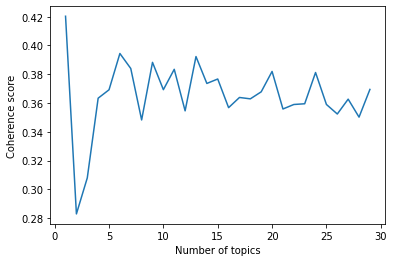

<Figure size 432x288 with 0 Axes>

In [ ]:
#5
import matplotlib.pyplot as plt
from gensim.models.ldamodel import LdaModel
from gensim.models import CoherenceModel 

# !pip install --upgrade gensim

max_topics = 30
num_of_topics = range(1, max_topics)
values = []
models = []
for i in num_of_topics:
    model = LdaModel(corpus=tweets_bow, num_topics = i)
    models.append(model)
    coh_model = CoherenceModel(model = model, texts = tweets_tokens, dictionary = tweets_dict, coherence='c_v')
    coherance_score = coh_model.get_coherence()
    values.append(coherance_score)

plt.plot(num_of_topics, values)
plt.xlabel("Number of topics")
plt.ylabel("Coherence score")
plt.show()
plt.savefig("coh_scores")

In [ ]:
new_values = values[1:]
max_value = max(new_values)
ind = values.index(max_value)
max_model = models[ind]
visualize = pyLDAvis.gensim_models.prepare(max_model, tweets_bow, tweets_dict)
visualize

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.033582 -0.154674       1        1  21.452579
4     -0.210038 -0.077254       2        1  21.190336
3     -0.110164 -0.097789       3        1  18.321357
5      0.375745 -0.146368       4        1  17.256733
2     -0.123205  0.113150       5        1  11.561960
1      0.101242  0.362935       6        1  10.217035, topic_info=        Term          Freq         Total Category  logprob  loglift
220     dose  65800.000000  65800.000000  Default  30.0000  30.0000
4838    slot  41365.000000  41365.000000  Default  29.0000  29.0000
277    avail  27237.000000  27237.000000  Default  28.0000  28.0000
121   approv  23614.000000  23614.000000  Default  27.0000  27.0000
127     paid  17071.000000  17071.000000  Default  26.0000  26.0000
...      ...           ...           ...      ...      ...      ...
1489       n   1281.969299   1343.511044   Topic6  -4.9190   2.2342
376     read   1196.888528   1788.234213   Topic6  -4.9877   1.8796
345   follow    878.485445   1487.246508   Topic6  -5.2970   1.7546
401   hospit   1016.278326   2644.666226   Topic6  -5.1512   1.3247
285        p    734.973886   1148.838057   Topic6  -5.4753   1.8344

[336 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
1801      2  0.986304     accept
1801      3  0.013474     accept
1604      4  0.998506        add
203       1  0.975607   administ
203       2  0.000473   administ
...     ...       ...        ...
768       1  0.999331  yesterday
441       1  0.000617        yet
441       2  0.998674        yet
1312      1  0.003945      young
1312      3  0.995017      young

[605 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 5, 4, 6, 3, 2])

Optimize the model using a new vector of features.

In [ ]:
import pandas as pd
import sys
import pickle
import numpy as np

from google.colab import drive
drive.mount('/content/gdrive')

df = pd.read_pickle("/content/gdrive/MyDrive/tede/eclass_all_with_sentiment_v2.pkl")

def sentiment_to_id(x):
  if x == 'NEG':
    return -1
  if x == 'NEU':
    return 0
  if x == 'POS':
    return 1

df['sentiment_ids'] = df['sentiment'].apply(sentiment_to_id)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Create two dictionaries, one for the words used in the positive tweets and one for the ones in the negative tweets and then subtract their common words.

In [ ]:
pos_words , neg_words = most_common_words = [pd.Series(' '.join(df.loc[df['sentiment_ids'] == sentiment]['text']).split()).value_counts() for sentiment in [ 1, -1]]
pos_words = pos_words.to_dict()
neg_words = neg_words.to_dict()

common = [x for x in pos_words if x in neg_words]

for key in common:
  del pos_words[key]
  del neg_words[key]

Export the vector of features from the train set, then split train and test datasets and extract new features such as the number of mentions of other users, the number of hashtags, the punctuation (usally showing some kind of emotion) and the number of capital letters (usally showing anger).


In [ ]:
from collections import Counter
import re

def words_count(tokens , dictionary):
    return len([x for x in tokens if x in dictionary])

def extract_feats(data):
    all_features = []
    for index , row in data.items():
        features = []
        text = row
        counts = Counter(text)

        features.append(counts['@'] if '@' in counts else 0) #number of user mentions
        features.append(counts['#'] if '#' in counts else 0) #number of hashtags
        features.append(counts['!'] if '!' in counts else 0) #number of !
        features.append(counts['?'] if '?' in counts else 0) #number of ?
        quot1 = counts['\''] if '\'' in counts else 0
        quot2 = counts['"'] if '"' in counts else 0
        features.append(quot1 + quot2)                       #total number of quotes
        features.append(sum(text.count(url) for url in ('http' , 'www')))  #number of urls
        count_capital = len(re.findall(r'[A-Z]',text))  #number of capital letters
        features.append(count_capital)
        tokens = text.split()
        features.append(words_count(tokens , pos_words ))    #number of words existing in positive tweets
        features.append(words_count(tokens , neg_words ))    #number of words existing in negative tweets
        all_features.append(features)
    return all_features


from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(df['text'], df['sentiment_ids'], train_size = 0.8)

my_xtrain = extract_feats(x_train)
my_xtest = extract_feats(x_test)

Test with SVM, Random Forest and K-Nearest Neighbors calssifiers and compare with the previous results.

In [ ]:

from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import cross_validate
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier


scoring = { 'precision' : make_scorer(precision_score, average = 'macro', zero_division=1),
           'recall' : make_scorer(recall_score, average = 'macro', zero_division=1),
           'f1_score' : make_scorer(f1_score, average = 'macro', zero_division=1), 
           'accuracy' : 'accuracy' }


def get_mean_scores(model, X, Y, scoring = 'accuracy', cv = 5) :
  score = cross_validate(model, X, Y, scoring = scoring, cv = cv )
  return {keys : np.mean(vals) for keys, vals in score.items()}


print("SVC results")
clf1 = SVC()
clf1.fit(my_xtrain, y_train)
scores_svc_6 = get_mean_scores(clf1, my_xtest, y_test, scoring = scoring, cv = 10 )
output = open('/content/gdrive/My Drive/tede/scores_svc_6.pkl', 'wb')
pickle.dump(scores_svc_6, output)
output.close()
print("Precision score ", scores_svc_6['test_precision'], "\nRecall score ", scores_svc_6['test_recall'], "\nf1 score ", scores_svc_6['test_f1_score'], "\nAccuracy score ", scores_svc_6['test_accuracy'])


print("\nRandom forest results")
clf2 = RandomForestClassifier(max_depth=30)
clf2.fit(my_xtrain, y_train)
scores_rf_6 = get_mean_scores(clf2, my_xtest, y_test, scoring = scoring, cv = 10 )
output = open('/content/gdrive/My Drive/tede/scores_rf_6.pkl', 'wb')
pickle.dump(scores_rf_6, output)
output.close()
print("Precision score ", scores_rf_6['test_precision'], "\nRecall score ", scores_rf_6['test_recall'], "\nf1 score ", scores_rf_6['test_f1_score'], "\nAccuracy score ", scores_rf_6['test_accuracy'])


print("\nKNeighbors results")
clf3 = KNeighborsClassifier(n_neighbors=10)
clf3.fit(my_xtrain, y_train)
scores_knn_6 = get_mean_scores(clf3, my_xtest, y_test, scoring = scoring, cv = 10 )
output = open('/content/gdrive/My Drive/tede/scores_knn_6.pkl', 'wb')
pickle.dump(scores_knn_6, output)
output.close()
print("Precision score ", scores_knn_6['test_precision'], "\nRecall score ", scores_knn_6['test_recall'], "\nf1 score ", scores_knn_6['test_f1_score'], "\nAccuracy score ", scores_knn_6['test_accuracy'])

SVC results
Precision score  0.8630077553100579 
Recall score  0.767095496596192 
f1 score  0.807568640518808 
Accuracy score  0.8872529621313715

Random forest results
Precision score  0.8306283669351465 
Recall score  0.7964705291283761 
f1 score  0.8124389311240119 
Accuracy score  0.8839006732051302

KNeighbors results
Precision score  0.844564750527082 
Recall score  0.7702485501884733 
f1 score  0.801463546813775 
Accuracy score  0.8821698842217727


Load every classifier's score so that it can be used later.

In [ ]:
scores_svc_bow = open('/content/gdrive/My Drive/tede/scores_svc_bow.pkl', 'rb')
scores_svc_bow = pickle.load(scores_svc_bow)

scores_svc_tfidf = open('/content/gdrive/My Drive/tede/scores_svc_tfidf.pkl', 'rb')
scores_svc_tfidf = pickle.load(scores_svc_tfidf)

scores_svc_we = open('/content/gdrive/My Drive/tede/scores_svc_we.pkl', 'rb')
scores_svc_we = pickle.load(scores_svc_we)

scores_rf_bow = open('/content/gdrive/My Drive/tede/scores_rf_bow.pkl', 'rb')
scores_rf_bow = pickle.load(scores_rf_bow)

scores_rf_tfidf = open('/content/gdrive/My Drive/tede/scores_rf_tfidf.pkl', 'rb')
scores_rf_tfidf = pickle.load(scores_rf_tfidf)

scores_rf_we = open('/content/gdrive/My Drive/tede/scores_rf_we.pkl', 'rb')
scores_rf_we = pickle.load(scores_rf_we)

scores_knn_bow = open('/content/gdrive/My Drive/tede/scores_knn_bow.pkl', 'rb')
scores_knn_bow = pickle.load(scores_knn_bow)

scores_knn_tfidf = open('/content/gdrive/My Drive/tede/scores_knn_tfidf.pkl', 'rb')
scores_knn_tfidf = pickle.load(scores_knn_tfidf)

scores_knn_we = open('/content/gdrive/My Drive/tede/scores_knn_we.pkl', 'rb')
scores_knn_we = pickle.load(scores_knn_we)

scores_svc_6 = open('/content/gdrive/My Drive/tede/scores_svc_6.pkl', 'rb')
scores_svc_6 = pickle.load(scores_svc_6)

scores_rf_6 = open('/content/gdrive/My Drive/tede/scores_rf_6.pkl', 'rb')
scores_rf_6 = pickle.load(scores_rf_6)

scores_knn_6 = open('/content/gdrive/My Drive/tede/scores_knn_6.pkl', 'rb')
scores_knn_6 = pickle.load(scores_knn_6)

Grouped bar chart for SVC with all the feature extraction methods used (Bag-Of-Word, TF-IDF, Word-Embeddings, new last method) and all the metrics used (Precision, Recall, F1, Accuracy).

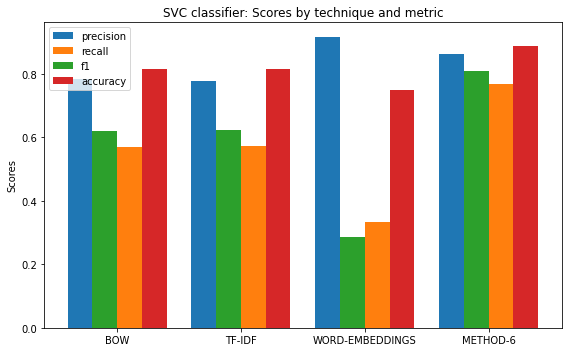

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

labels = ['BOW', 'TF-IDF', 'WORD-EMBEDDINGS', 'METHOD-6']
precision = [scores_svc_bow['test_precision'], scores_svc_tfidf['test_precision'], scores_svc_we['test_precision'], scores_svc_6['test_precision']]
recall = [scores_svc_bow['test_recall'], scores_svc_tfidf['test_recall'], scores_svc_we['test_recall'], scores_svc_6['test_recall']]
f1 = [scores_svc_bow['test_f1_score'], scores_svc_tfidf['test_f1_score'], scores_svc_we['test_f1_score'], scores_svc_6['test_f1_score']]
accuracy = [scores_svc_bow['test_accuracy'], scores_svc_tfidf['test_accuracy'], scores_svc_we['test_accuracy'], scores_svc_6['test_accuracy']]

x = np.arange(len(labels))  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots(figsize=(8,5))
rects1 = ax.bar(x - 6*width/4, precision, width, label='precision')
rects2 = ax.bar(x + width/2, recall, width, label='recall')
rects3 = ax.bar(x - width/2, f1, width, label='f1')
rects4 = ax.bar(x + 6*width/4, accuracy, width, label='accuracy')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('SVC classifier: Scores by technique and metric')
plt.xticks([0,1,2,3], labels)
ax.legend()

fig.tight_layout()

Grouped bar chart for Random Forest with all the feature extraction methods used (Bag-Of-Word, TF-IDF, Word-Embeddings, new last method) and all the metrics used (Precision, Recall, F1, Accuracy).

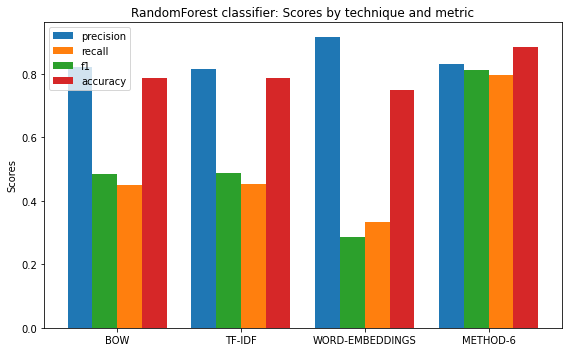

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

labels = ['BOW', 'TF-IDF', 'WORD-EMBEDDINGS', 'METHOD-6']
precision = [scores_rf_bow['test_precision'], scores_rf_tfidf['test_precision'], scores_rf_we['test_precision'], scores_rf_6['test_precision']]
recall = [scores_rf_bow['test_recall'], scores_rf_tfidf['test_recall'], scores_rf_we['test_recall'], scores_rf_6['test_recall']]
f1 = [scores_rf_bow['test_f1_score'], scores_rf_tfidf['test_f1_score'], scores_rf_we['test_f1_score'], scores_rf_6['test_f1_score']]
accuracy = [scores_rf_bow['test_accuracy'], scores_rf_tfidf['test_accuracy'], scores_rf_we['test_accuracy'], scores_rf_6['test_accuracy']]

x = np.arange(len(labels))  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots(figsize=(8,5))
rects1 = ax.bar(x - 6*width/4, precision, width, label='precision')
rects2 = ax.bar(x + width/2, recall, width, label='recall')
rects3 = ax.bar(x - width/2, f1, width, label='f1')
rects4 = ax.bar(x + 6*width/4, accuracy, width, label='accuracy')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('RandomForest classifier: Scores by technique and metric')
plt.xticks([0,1,2,3], labels)
ax.legend()

fig.tight_layout()

Grouped bar chart for K-Nearest Neighbors with all the feature extraction methods used (Bag-Of-Word, TF-IDF, Word-Embeddings, new last method) and all the metrics used (Precision, Recall, F1, Accuracy).

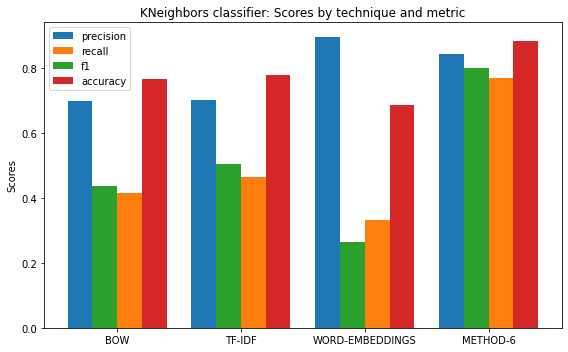

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

labels = ['BOW', 'TF-IDF', 'WORD-EMBEDDINGS', 'METHOD-6']
precision = [scores_knn_bow['test_precision'], scores_knn_tfidf['test_precision'], scores_knn_we['test_precision'], scores_knn_6['test_precision']]
recall = [scores_knn_bow['test_recall'], scores_knn_tfidf['test_recall'], scores_knn_we['test_recall'], scores_knn_6['test_recall']]
f1 = [scores_knn_bow['test_f1_score'], scores_knn_tfidf['test_f1_score'], scores_knn_we['test_f1_score'], scores_knn_6['test_f1_score']]
accuracy = [scores_knn_bow['test_accuracy'], scores_knn_tfidf['test_accuracy'], scores_knn_we['test_accuracy'], scores_knn_6['test_accuracy']]

x = np.arange(len(labels))  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots(figsize=(8,5))
rects1 = ax.bar(x - 6*width/4, precision, width, label='precision')
rects2 = ax.bar(x + width/2, recall, width, label='recall')
rects3 = ax.bar(x - width/2, f1, width, label='f1')
rects4 = ax.bar(x + 6*width/4, accuracy, width, label='accuracy')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('KNeighbors classifier: Scores by technique and metric')
plt.xticks([0,1,2,3], labels)
ax.legend()

fig.tight_layout()